# Quantum Teleporation

In [8]:
import numpy as np
import pandas as pd

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector, state_fidelity, DensityMatrix, partial_trace

### Classical measurement bits 
 - Created a classical bit measurement circuit.
 - The quantum state will collapse upon measurement.
 - Conditional gates applied with if_test on one and only classical register (2 bits)
 - We will be matching the result counts of psi state and the q2's final state after adjustment

In [10]:
sim = AerSimulator()

def cl_circuit(prep_state=None, shots=1024):
    
    if prep_state==None:
        prep_state=[1, 0]

    qc = QuantumCircuit(3, 2)

    # Prepared unknown psi state
    qc.initialize(prep_state, 0)
    
    # Prepared bell pair
    qc.h(1)
    qc.cx(1, 2)

    # q0 entangled with half bell pair
    qc.cx(0, 1)

    # Adjusted basis of measurement to include phase shift
    qc.h(0)

    qc.measure([0, 1],  # q0 and q1 
               [0, 1])  # c0 and c1

    # Apply classical corrections to q2 using if_test tuple (ClassicalRegister, int)
    # qc.cregs[0] is the only 2-bit classical register:
    # 0 -> 00, 1 -> 01, 2 -> 10, 3 -> 11
    with qc.if_test((qc.cregs[0], 1)):  # measured 01  -> apply X
        qc.x(2)
    with qc.if_test((qc.cregs[0], 2)):  # measured 10  -> apply Z
        qc.z(2)
    with qc.if_test((qc.cregs[0], 3)):  # measured 11  -> apply Z then X
        qc.z(2)
        qc.x(2)

    # measuring q2 to confirm results, reusing the cbit 1 here for convenience
    qc.measure(2, 1)

    compiled_qc = transpile(circuits=qc, backend=sim)
    result = sim.run(circuits=compiled_qc, shots=shots).result()
    counts = result.get_counts()
    return qc, counts


Calling the classical bit circuit and print its final counts after adjustment

{'00': 264, '10': 237, '11': 265, '01': 258}


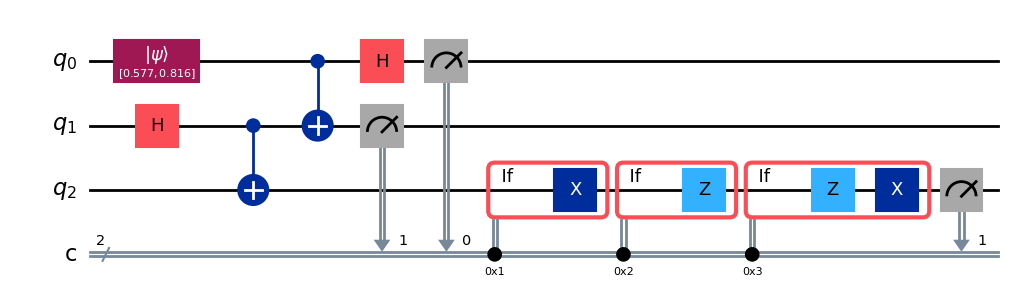

In [11]:
psi = [np.sqrt(1/3), np.sqrt(2/3)]
qc_cl, counts = cl_circuit(prep_state=psi)
print(counts)
qc_cl.draw('mpl')

### State Vector measurement
 - No classical measurement on classical bits, hence the state will not collapse. And the adjustments are done using **quantum gates** *cx* and *cz* gates
 - Statevector converted to Density Matrix, because it handles both pure and mixed states. And it helps with Partial trace. 
 - Partial trace of q0 and q1 and only q2's state is taken into consideration
 - Fidelity measures the _similarity (overlap)_ between the initial state ∣ψ⟩ and the final state of q₂.
	 - Imagine two arrows on the Bloch sphere, fidelity is how much they point in the same direction.

In [ ]:
def sv_circuit(prep_state=None):
    if prep_state==None:
        prep_state=[1, 0]

    qc = QuantumCircuit(3)

    # Prepared unknown psi state
    qc.initialize(prep_state, 0)
    
    # Prepared bell pair
    qc.h(1)
    qc.cx(1, 2)

    # q0 entangled with half bell pair
    qc.cx(0, 1)

    # Adjusted basis of measurement to include phase shift
    qc.h(0)

    # Controlled X quantum correction
    qc.cx(1, 2)

    # Controlled Z quantum correction
    qc.cz(0, 2)

    # Run the circuit to get statevector
    sv = Statevector.from_instruction(qc)

    # Initial state q0 |psi>:
    psi = Statevector(prep_state)

    # Get density matrix of q2:
    dm = DensityMatrix(sv) # ρ=∣ψ⟩⟨ψ∣, ⟨ψ∣ is conjugate tranpose of ∣ψ⟩
    dm_q2 = partial_trace(dm, [0, 1])  # trace out q0 and q1, ρ_q2​=Tr_(q0,q1​).(ρfull​)

    # fidelity between pure psi and rho:
    fid = state_fidelity(psi, dm_q2) # F(∣ψ⟩,∣ϕ⟩)=∣⟨ψ∣ϕ⟩∣^2
    return fid, qc, sv

- When we get a statevector in form q0,q1,q2 (3 bit register), these
   are the probability amplitude of the different 3 bit states.
- Absolute Squares of these values and their sum should equate to 1   
   (probability of system)

Fidelity between initial q0 and teleported q2: 0.9999999999999997
Statevector([0.28867513+0.j, 0.28867513+0.j, 0.28867513+0.j,
             0.28867513+0.j, 0.40824829+0.j, 0.40824829+0.j,
             0.40824829+0.j, 0.40824829+0.j],
            dims=(2, 2, 2))


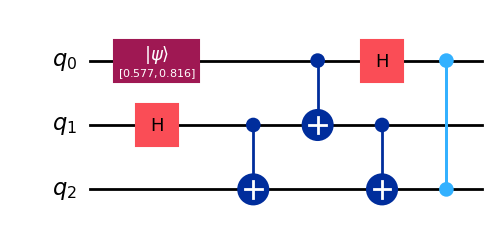

In [ ]:
psi = [np.sqrt(1/3), np.sqrt(2/3)]
fid, qc_sv, sv = sv_circuit(prep_state=psi)
print("Fidelity between initial q0 and teleported q2:", fid)
print(sv) # |q0 q1 q2>
qc_sv.draw('mpl')